In [1]:
import datetime as dt
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')
#c = conn.cursor()

In [3]:
df = pd.read_sql_query("SELECT STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)

In [4]:
print(df.head())

  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  FIRE_SIZE
0    Miscellaneous  40.036944 -121.005833    CA       2453403.5       0.10
1        Lightning  38.933056 -120.404444    CA       2453137.5       0.25
2   Debris Burning  38.984167 -120.735556    CA       2453156.5       0.10
3        Lightning  38.559167 -119.913333    CA       2453184.5       0.10
4        Lightning  38.559167 -119.933056    CA       2453184.5       0.10


In [5]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DAY_OF_WEEK'] = pd.to_datetime(df['DATE']).dt.weekday_name
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month

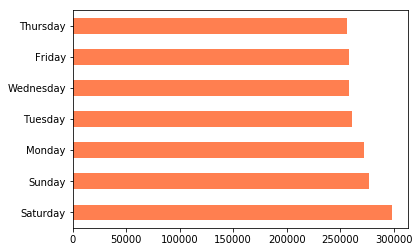

In [6]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

In [7]:
temp_df =df.groupby(['STAT_CAUSE_DESCR']).size().reset_index(name='count')

In [8]:
print(temp_df)

     STAT_CAUSE_DESCR   count
0               Arson  281455
1            Campfire   76139
2            Children   61167
3      Debris Burning  429028
4       Equipment Use  147612
5           Fireworks   11500
6           Lightning  278468
7       Miscellaneous  323805
8   Missing/Undefined  166723
9           Powerline   14448
10           Railroad   33455
11            Smoking   52869
12          Structure    3796


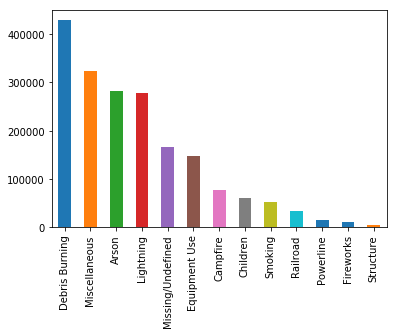

In [9]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar')

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
print(df.head())

   STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  FIRE_SIZE  \
0                 7  40.036944 -121.005833      4       2453403.5       0.10   
1                 6  38.933056 -120.404444      4       2453137.5       0.25   
2                 3  38.984167 -120.735556      4       2453156.5       0.10   
3                 6  38.559167 -119.913333      4       2453184.5       0.10   
4                 6  38.559167 -119.933056      4       2453184.5       0.10   

        DATE  DAY_OF_WEEK  MONTH  
0 2005-02-02            6      2  
1 2004-05-12            6      5  
2 2004-05-31            1      5  
3 2004-06-28            1      6  
4 2004-06-28            1      6  


                  STAT_CAUSE_DESCR  LATITUDE  LONGITUDE     STATE  \
STAT_CAUSE_DESCR          1.000000  0.012729  -0.123879  0.036004   
LATITUDE                  0.012729  1.000000  -0.354727  0.152474   
LONGITUDE                -0.123879 -0.354727   1.000000  0.207575   
STATE                     0.036004  0.152474   0.207575  1.000000   
DISCOVERY_DATE            0.052475  0.005821   0.006870  0.100746   
FIRE_SIZE                 0.010450  0.038860  -0.039731 -0.008003   
DAY_OF_WEEK               0.007523 -0.003110  -0.004100 -0.002518   
MONTH                     0.057583  0.147484  -0.243395 -0.034804   

                  DISCOVERY_DATE  FIRE_SIZE  DAY_OF_WEEK     MONTH  
STAT_CAUSE_DESCR        0.052475   0.010450     0.007523  0.057583  
LATITUDE                0.005821   0.038860    -0.003110  0.147484  
LONGITUDE               0.006870  -0.039731    -0.004100 -0.243395  
STATE                   0.100746  -0.008003    -0.002518 -0.034804  
DISCOVERY_DATE          1.000000 

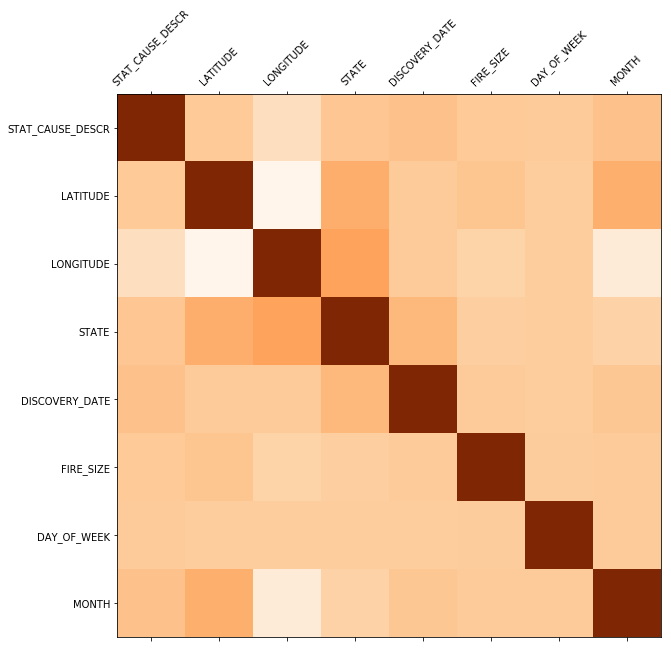

In [11]:
import matplotlib.pyplot as plt
def heat_map(df,size=10):
    corr = df.corr()  #the default method is pearson
    print(corr)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
heat_map(df)

In [12]:
from sklearn import svm
from sklearn.model_selection import train_test_split  

df = df.head(50000)
df['DATE'] = pd.to_numeric(df['DATE'], errors='coerce') #converting from timestamp to numeric value
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'STAT_CAUSE_DESCR'], df['STAT_CAUSE_DESCR'], test_size = 0.20)
clf = svm.SVC(gamma='scale')

clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
y_true = clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_test)
y_true 

array([1, 6, 7, ..., 6, 6, 6])